--- 1. 数据加载与预处理 ---


d:\environment_variables\Python312\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


成功读取文件: 实验二.xlsx
原始数据前5行:
           买家会员名  买家实际支付积分  买家实际支付金额  买家应付货款  买家应付邮费              买家支付宝账号  \
0         qust99         0    143.64  143.64       0     190414156@qq.com   
1  songjones4000         0     55.86   55.86       0          13224268598   
2          133王超         0     55.86   55.86       0  13283421509@163.com   
3           扛扛大人         0     48.86   48.86       0          18556356916   
4            楠楠途         0      0.00  268.00       0    1031213843@qq.com   

   买家支付积分 买家服务费                                      买家留言  修改后的sku  ... 联系电话   \
0       0    0元  开发票：青岛欧特思自动化科技有限公司，税号：91370213MA3CJTQ95N      NaN  ...   NaN   
1       0    0元                                       NaN      NaN  ...   NaN   
2       0    0元                                       NaN      NaN  ...   NaN   
3       0    0元                                       NaN      NaN  ...   NaN   
4       0    0元                                       NaN      NaN  ...   NaN   

               订单付款时间  订

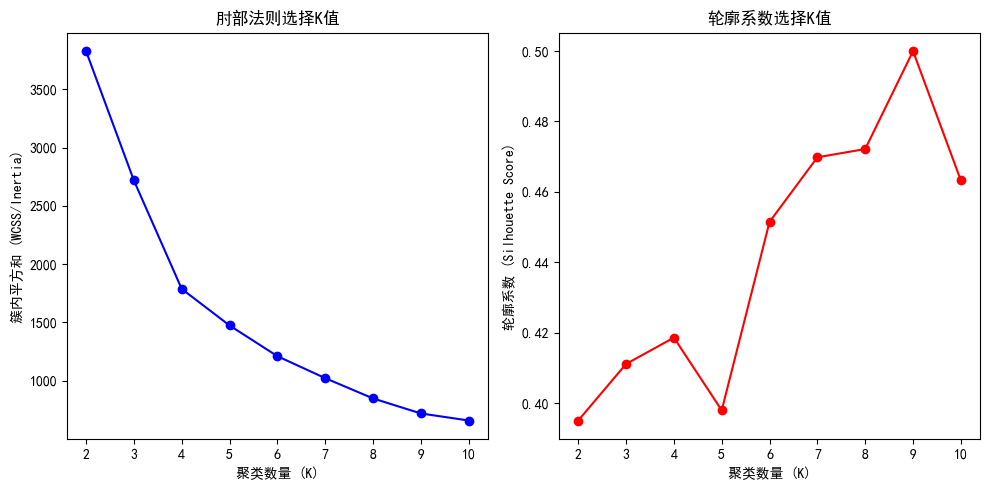


根据图形分析，选择 K = 4

已将客户分配到 4 个簇中 (前5行):
                Recency  Frequency  Monetary  Cluster
CustomerID                                           
00牛哥哥00             694          2    402.00        1
020luo              409          1     74.70        1
0587xueguangju      626          1    268.00        1
0o秋天de童话             83          2    411.50        0
0残缺0                346          1     48.86        1

--- 5. 聚类结果评价 ---
最终聚类 (K=4) 的轮廓系数: 0.4186

各簇RFM均值及客户数量:
         Recency_Mean  Frequency_Mean  Monetary_Mean  Cluster_Size
Cluster                                                           
3           87.000000        4.000000   13003.000000             2
2          314.262712        3.745763     796.166356           118
1          468.376190        1.153571     214.180762           840
0          148.055085        1.207627     159.230734           708

--- 6. 结果可视化 ---


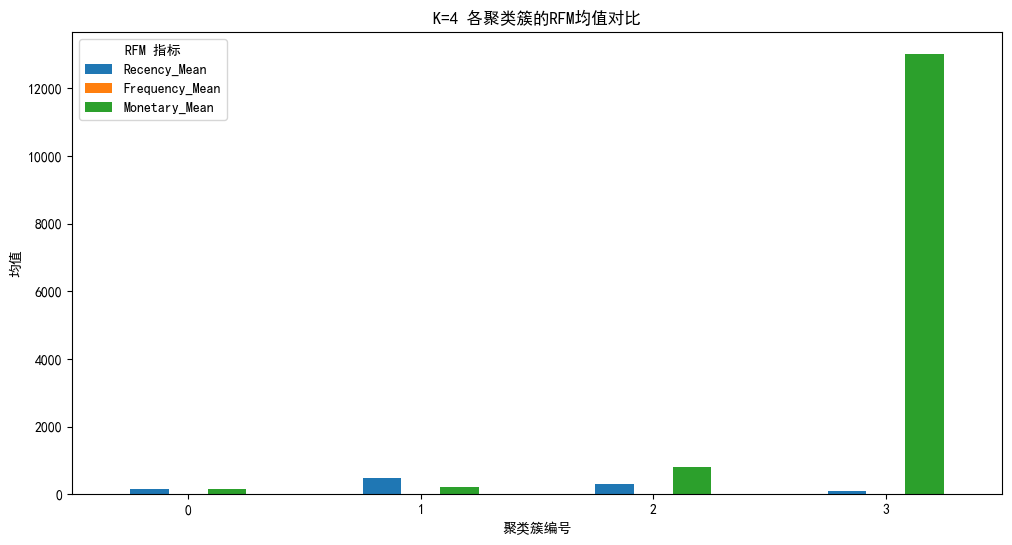

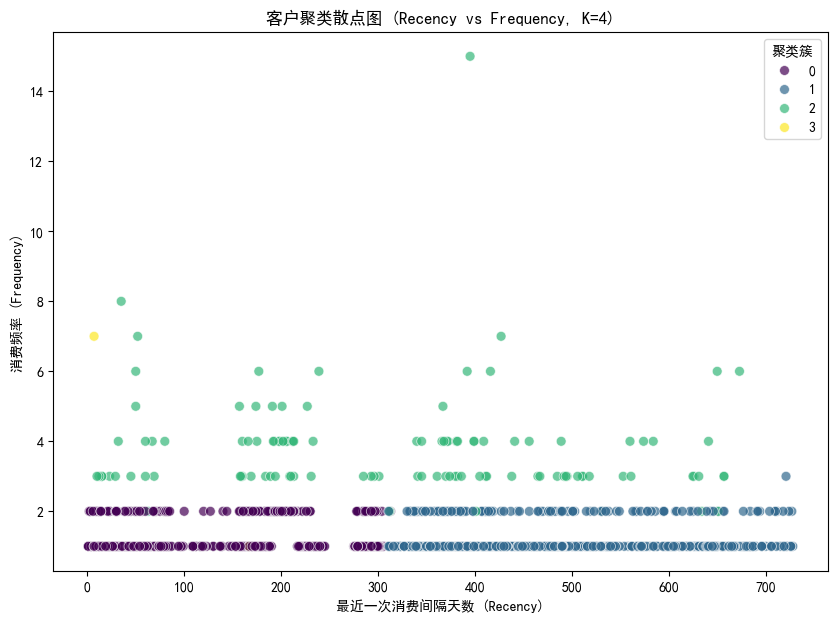

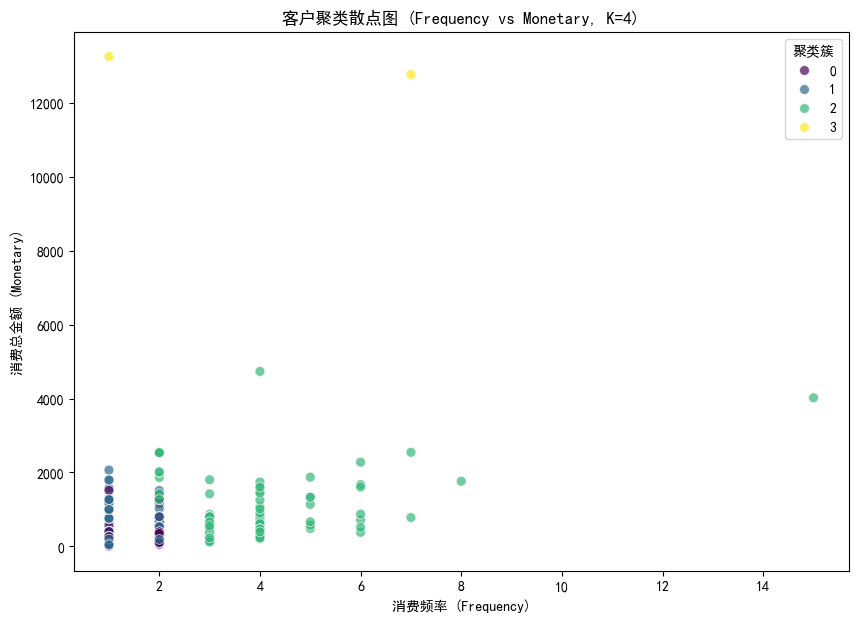

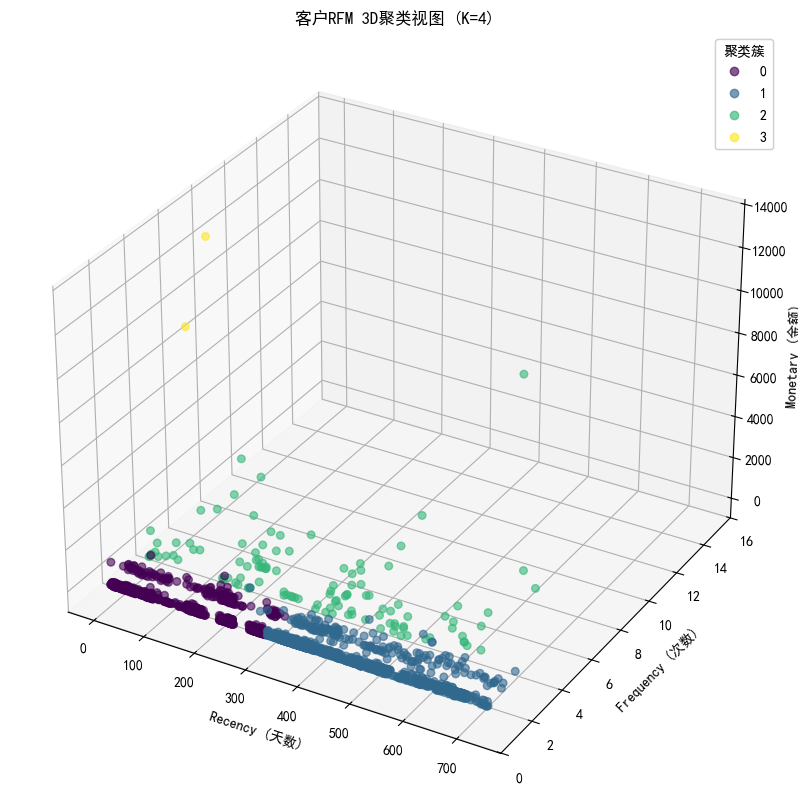


--- 7. 聚类结果解读示例 (请根据你的实际结果调整) ---

实验完成！


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
# 为了中文显示正常
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

# --- 1. 数据加载与预处理 ---
print("--- 1. 数据加载与预处理 ---")
# **重要:** 请将 '你的数据文件路径.xlsx' 替换为你的实际文件路径
file_path = '实验二.xlsx' # <--- 修改这里

try:
    # 读取Excel文件，可以指定sheet_name如果不在第一个sheet
    df_raw = pd.read_excel(file_path)
    print(f"成功读取文件: {file_path}")
    print("原始数据前5行:")
    print(df_raw.head())
    print("\n原始数据信息:")
    df_raw.info()

    # 选择RFM分析所需列，并重命名为英文，方便处理
    # 注意：这里根据你提供的列名选择，请确保列名完全匹配
    relevant_cols = {
        '买家会员名': 'CustomerID',
        '订单创建时间': 'OrderDate',
        '买家实际支付金额': 'Amount'
        # 如果有唯一的订单ID列，也可以加入用于计算频次，例如 '订单编号': 'OrderID'
    }
    
    # 检查所需列是否存在
    missing_cols = [col for col in relevant_cols.keys() if col not in df_raw.columns]
    if missing_cols:
        raise ValueError(f"错误：数据文件中缺少以下必需列: {', '.join(missing_cols)}")

    df = df_raw[list(relevant_cols.keys())].copy()
    df.rename(columns=relevant_cols, inplace=True)

    # 数据清洗
    # 删除CustomerID或Amount为空的行
    df.dropna(subset=['CustomerID', 'Amount'], inplace=True)

    # 转换数据类型
    # 将OrderDate转换为datetime对象，忽略无法转换的错误
    df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')
    # 删除OrderDate转换失败的行
    df.dropna(subset=['OrderDate'], inplace=True)

    # 将Amount转换为数值类型，处理可能存在的非数值（如'元'）
    if df['Amount'].dtype == 'object':
         # 尝试去除 '元' 等非数字字符，然后转换
         df['Amount'] = df['Amount'].astype(str).str.replace('元', '', regex=False).str.strip()
         df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    elif not pd.api.types.is_numeric_dtype(df['Amount']):
         df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

    # 删除Amount转换失败或小于等于0的行 (通常消费金额>0)
    df.dropna(subset=['Amount'], inplace=True)
    df = df[df['Amount'] > 0]

    print("\n预处理后数据前5行:")
    print(df.head())
    print("\n预处理后数据信息:")
    df.info()
    print(f"预处理后剩余记录数: {len(df)}")

    if df.empty:
        raise ValueError("错误：预处理后没有有效数据，请检查原始数据和预处理步骤。")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径 '{file_path}' 是否正确。")
    exit()
except ValueError as ve:
    print(ve)
    exit()
except Exception as e:
    print(f"读取或预处理数据时发生未知错误: {e}")
    exit()

# --- 2. 计算RFM指标 ---
print("\n--- 2. 计算RFM指标 ---")

# 确定快照日期 (Snapshot Date) - 通常是最后交易日期+1天
snapshot_date = df['OrderDate'].max() + dt.timedelta(days=1)
print(f"数据快照日期 (用于计算Recency): {snapshot_date.strftime('%Y-%m-%d')}")

# 按客户分组计算RFM
rfm = df.groupby('CustomerID').agg(
    # Recency: 计算最后购买日期与快照日期的天数差
    Recency=('OrderDate', lambda x: (snapshot_date - x.max()).days),
    # Frequency: 计算购买次数 (每个记录算一次购买)
    Frequency=('OrderDate', 'count'),
    # Monetary: 计算总购买金额
    Monetary=('Amount', 'sum')
)

# 查看RFM结果
print("\n计算得到的RFM值 (前5行):")
print(rfm.head())
print("\nRFM数据描述性统计:")
print(rfm.describe())

# 将计算好的RFM数据保存到文件 (例如CSV)
try:
    rfm_output_path = 'rfm_analysis_results.csv'
    rfm.to_csv(rfm_output_path)
    print(f"\nRFM结果已保存到: {rfm_output_path}")
    # 如果需要保存为Excel:
    # rfm_excel_path = 'rfm_analysis_results.xlsx'
    # rfm.to_excel(rfm_excel_path)
    # print(f"RFM结果已保存到: {rfm_excel_path}")
except Exception as e:
    print(f"保存RFM结果时出错: {e}")


# --- 3. 数据标准化 ---
print("\n--- 3. 数据标准化 ---")

# 检查RFM数据是否有inf或NaN（理论上不应有，但以防万一）
if rfm.isnull().values.any() or np.isinf(rfm.values).any():
    print("警告：RFM数据中存在NaN或Inf值，尝试填充或删除...")
    # 处理策略：可以用0填充，或删除对应行，这里选择删除
    rfm.replace([np.inf, -np.inf], np.nan, inplace=True)
    rfm.dropna(inplace=True)
    print("已处理NaN/Inf值。")

if rfm.empty:
    print("错误：标准化前RFM数据为空，无法继续。")
    exit()
    
# 提取需要标准化的特征
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# 使用StandardScaler进行Z-score标准化
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# 将标准化后的数据转回DataFrame，方便后续使用
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['R_scaled', 'F_scaled', 'M_scaled'])

print("\n标准化后的RFM数据 (前5行):")
print(rfm_scaled_df.head())

# --- 4. K-Means聚类 ---
print("\n--- 4. K-Means聚类 ---")

# 4.1 选择最优K值 (肘部法则 和 轮廓系数)
inertia = [] # WCSS (Within-Cluster Sum of Squares)
silhouette_scores = []
k_range = range(2, 11) # 尝试聚类数量从2到10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' in newer versions
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)
    # 轮廓系数需要至少2个簇
    score = silhouette_score(rfm_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}, WCSS={kmeans.inertia_:.2f}, Silhouette Score={score:.4f}")

# 绘制肘部法则图
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('聚类数量 (K)')
plt.ylabel('簇内平方和 (WCSS/Inertia)')
plt.title('肘部法则选择K值')

# 绘制轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('聚类数量 (K)')
plt.ylabel('轮廓系数 (Silhouette Score)')
plt.title('轮廓系数选择K值')

plt.tight_layout()
plt.show()

# 4.2 根据图形选择K值
# 分析：肘部法则看曲线斜率变化趋于平缓的“肘点”
# 分析：轮廓系数选择得分最高的K值
# **需要人工观察上面的图形来决定最佳K值**
# 假设我们根据图形选择了 K=4 (这里只是示例，你需要根据实际图形判断)
chosen_k = 4 # <--- **根据你的图形分析结果修改这里的K值**
print(f"\n根据图形分析，选择 K = {chosen_k}")

# 4.3 执行最终的K-Means聚类
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled_df)

# 获取聚类标签
cluster_labels = kmeans_final.labels_

# 将聚类标签添加回原始RFM数据框
rfm['Cluster'] = cluster_labels

print(f"\n已将客户分配到 {chosen_k} 个簇中 (前5行):")
print(rfm.head())

# --- 5. 聚类结果评价 ---
print("\n--- 5. 聚类结果评价 ---")
final_silhouette_score = silhouette_score(rfm_scaled_df, cluster_labels)
print(f"最终聚类 (K={chosen_k}) 的轮廓系数: {final_silhouette_score:.4f}")
# 轮廓系数解释：
# 接近1: 聚类效果好，簇内紧密，簇间距离远。
# 接近0: 簇与簇之间有重叠，或者样本点离簇边界很近。
# 接近-1: 样本点可能被分到了错误的簇。

# 分析每个簇的RFM均值，理解簇的特征
cluster_summary = rfm.groupby('Cluster').agg(
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean'),
    Cluster_Size=('Recency', 'count') # 查看每个簇有多少客户
)
print("\n各簇RFM均值及客户数量:")
print(cluster_summary.sort_values(by='Monetary_Mean', ascending=False)) # 按消费金额排序方便看高价值客户

# --- 6. 结果可视化 ---
print("\n--- 6. 结果可视化 ---")

# 6.1 各簇RFM均值柱状图
cluster_summary_plot = cluster_summary[['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']]
# 由于R值是越小越好，为了可视化方便（都希望越高越好），可以取其倒数或用 (最大R - R)
# 这里我们直接绘制，但在解读时要注意R的意义
cluster_summary_plot.plot(kind='bar', figsize=(12, 6))
plt.title(f'K={chosen_k} 各聚类簇的RFM均值对比')
plt.ylabel('均值')
plt.xlabel('聚类簇编号')
plt.xticks(rotation=0)
plt.legend(title='RFM 指标')
plt.show()


# 6.2 RFM两两组合散点图 (以R和F为例，用颜色区分簇)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title(f'客户聚类散点图 (Recency vs Frequency, K={chosen_k})')
plt.xlabel('最近一次消费间隔天数 (Recency)')
plt.ylabel('消费频率 (Frequency)')
plt.legend(title='聚类簇')
plt.show()

# 6.3 RFM两两组合散点图 (以F和M为例，用颜色区分簇)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title(f'客户聚类散点图 (Frequency vs Monetary, K={chosen_k})')
plt.xlabel('消费频率 (Frequency)')
plt.ylabel('消费总金额 (Monetary)')
plt.legend(title='聚类簇')
plt.show()

# 6.4 [可选] 3D散点图 (需要安装 matplotlib)
try:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
                         c=rfm['Cluster'], cmap='viridis', s=30, alpha=0.6)

    ax.set_xlabel('Recency (天数)')
    ax.set_ylabel('Frequency (次数)')
    ax.set_zlabel('Monetary (金额)')
    ax.set_title(f'客户RFM 3D聚类视图 (K={chosen_k})')
    
    # 添加颜色条
    legend1 = ax.legend(*scatter.legend_elements(), title="聚类簇")
    ax.add_artist(legend1)
    
    # 反转Recency轴，使得更近的点在前面 (可选)
    # ax.invert_xaxis() 

    plt.show()
except ImportError:
    print("\n提示：未安装 matplotlib 的 3D 工具包，跳过3D散点图绘制。")
except Exception as e:
    print(f"\n绘制3D散点图时出错: {e}")


# --- 7. 结果解读 (基于cluster_summary) ---
print("\n--- 7. 聚类结果解读示例 (请根据你的实际结果调整) ---")
# 例如，假设K=4，并且根据上面打印的cluster_summary分析：
# 簇0: R低, F高, M高 -> 重要价值客户 (最近买、经常买、花钱多)
# 簇1: R低, F低, M低 -> 新客户/低价值客户 (最近买，但不常买，花钱少)
# 簇2: R高, F低, M低 -> 流失风险客户/低价值流失客户 (很久没买，买的次数少，花钱少)
# 簇3: R高, F高, M高 -> 重要保持客户 (曾经是高价值，但最近没买，需要挽回)
# ...等等，你需要根据你的具体数据和cluster_summary表格来命名和解释每个簇。

print("\n实验完成！")